<a href="https://colab.research.google.com/github/Hanishkaa01/DEEP-LEARNING-TECHNIQUES-LAB-EXP/blob/main/exp12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step
Epoch 1/2 | Gen Loss: 3.1989 | Disc Loss: 0.2433 | Time: 6.68s


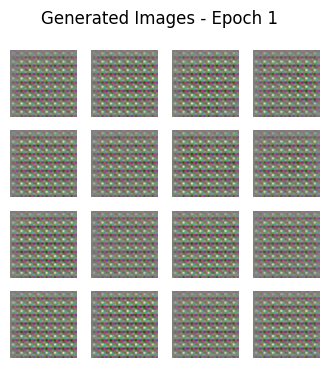

Epoch 2/2 | Gen Loss: 1.7013 | Disc Loss: 0.2882 | Time: 0.78s


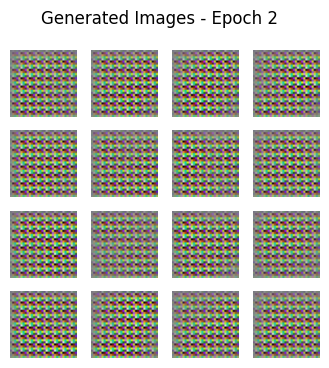

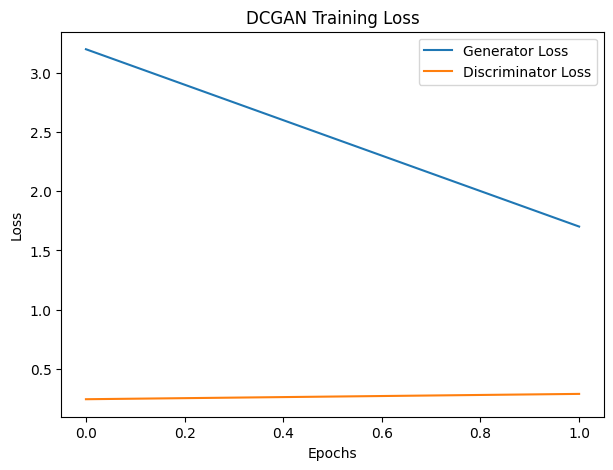

In [ ]:
# ✅ Lab 12 (Fast Version): DCGAN to Generate Color Images (CIFAR-10)
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import time

# 1️⃣ Load & Preprocess CIFAR-10 (subset for speed)
(x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
x_train = (x_train.astype("float32") - 127.5) / 127.5  # normalize to [-1,1]
x_train = x_train[:5000]  # only 5k images for faster training

BUFFER_SIZE = 5000
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 2️⃣ Generator
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(100,)),
        layers.Dense(8*8*128, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding="same", use_bias=False, activation="tanh"),
    ])
    return model

# 3️⃣ Discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(64, (5,5), strides=(2,2), padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5,5), strides=(2,2), padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

generator = build_generator()
discriminator = build_discriminator()

# 4️⃣ Loss + Optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = (
            cross_entropy(tf.ones_like(real_output), real_output)
            + cross_entropy(tf.zeros_like(fake_output), fake_output)
        )
    grads_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grads_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gen_optimizer.apply_gradients(zip(grads_gen, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(grads_disc, discriminator.trainable_variables))
    return gen_loss, disc_loss

# 5️⃣ Training (Quick Version)
EPOCHS = 2
seed = tf.random.normal([16, 100])
gen_losses, disc_losses = [], []

for epoch in range(EPOCHS):
    start = time.time()
    for image_batch in train_dataset.take(100):  # only 100 batches for speed
        g_loss, d_loss = train_step(image_batch)
    gen_losses.append(g_loss.numpy())
    disc_losses.append(d_loss.numpy())

    print(f"Epoch {epoch+1}/{EPOCHS} | Gen Loss: {g_loss:.4f} | Disc Loss: {d_loss:.4f} | Time: {time.time()-start:.2f}s")

    # Show generated samples
    predictions = generator(seed, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] * 0.5 + 0.5))
        plt.axis("off")
    plt.suptitle(f"Generated Images - Epoch {epoch+1}")
    plt.show()

# 6️⃣ Plot Loss Graph
plt.figure(figsize=(7,5))
plt.plot(gen_losses, label="Generator Loss")
plt.plot(disc_losses, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("DCGAN Training Loss")
plt.show()